In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import gaussian_kde
from stockwell import st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import lombscargle
np.random.seed(42)


## HD10180

In [28]:
data = pd.read_csv('HD10180(Sheet1).csv', skiprows = 1)
time = data.iloc[:, 0].values
rv_data = data.iloc[:, 1].values

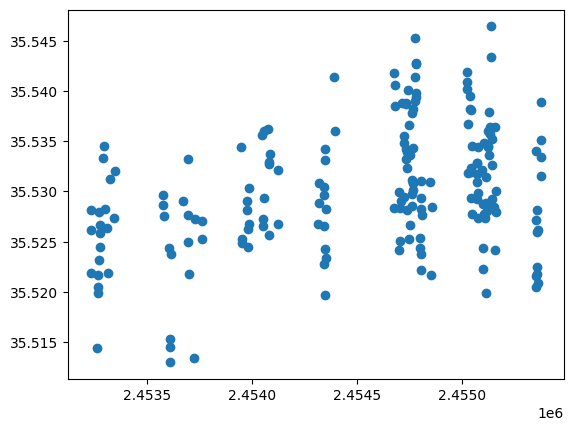

In [3]:
plt.scatter(time, rv_data, label = "scatter")

## GLS

Loading data from HD10180(Sheet1).csv...
  Assuming data starts on row 2.
  Third column found and is numeric, using as uncertainties (e_RV).
  Successfully loaded and prepared 190 data points.
Computing Lomb-Scargle periodogram...

To see higher frequencies, you can change the ax.set_xlim() value in the code.
For example, change it to ax.set_xlim(0, 1.2) to see the region of the ~1.18d candidate.


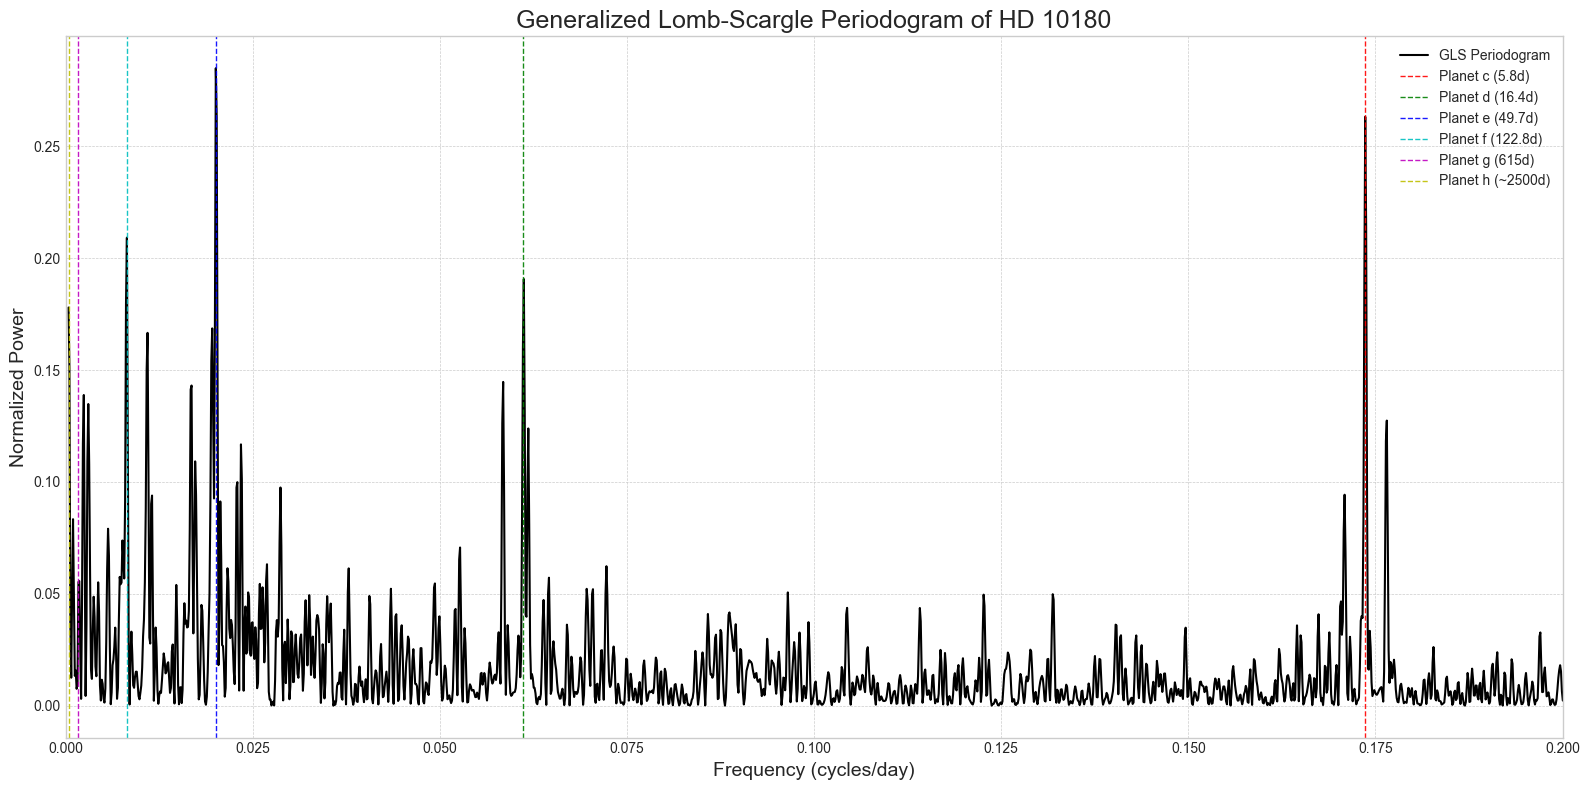

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import lombscargle

def load_and_prepare_data(filepath):
    print(f"Loading data from {filepath}...")
    try:
        df = pd.read_csv(filepath, header=None)
    except FileNotFoundError:
        print(f"ERROR: File not found at '{filepath}'. Please check the file path.")
        return None, None, None
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return None, None, None

    first_data_row = 0
    for i, row in df.iterrows():
        try:
            pd.to_numeric(row.iloc[0])
            pd.to_numeric(row.iloc[1])
            first_data_row = i
            break 
        except (ValueError, TypeError):
            continue 
    
    print(f"  Assuming data starts on row {first_data_row + 1}.")
    df = df.iloc[first_data_row:].copy()
    times = pd.to_numeric(df.iloc[:, 0]).values
    rv_data = pd.to_numeric(df.iloc[:, 1]).values*1000
    rv_data = rv_data - np.mean(rv_data)
    
    # Check for the uncertainty column (e_RV) in the third position
    if df.shape[1] >= 3 and pd.to_numeric(df.iloc[:, 2], errors='coerce').notna().all():
        print("  Third column found and is numeric, using as uncertainties (e_RV).")
        uncertainties = pd.to_numeric(df.iloc[:, 2]).values
    else:
        print("  Uncertainty column not found. Using uniform uncertainties of 1.0.")
        uncertainties = np.ones_like(rv_data)

    print(f"  Successfully loaded and prepared {len(times)} data points.")
    return times, rv_data, uncertainties

def run_gls_analysis(times, rv_data, uncertainties):
    print("Computing Lomb-Scargle periodogram...")
    freq_grid = np.linspace(0.0004, 1.2, 10000)
    
    angular_freqs = 2 * np.pi * freq_grid
    
    power = lombscargle(times, rv_data, angular_freqs, precenter=True, normalize=True)

    # --- Plotting ---
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(16, 8))
    
    ax.plot(freq_grid, power, 'k-', lw=1.5, label='GLS Periodogram')
    known_periods = {
        'c (5.8d)': 5.759, 'd (16.4d)': 16.357, 'e (49.7d)': 49.748, 
        'f (122.8d)': 122.744, 'g (615d)': 615.0, 'h (~2500d)': 2500.0
    }
    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    for i, (name, period) in enumerate(known_periods.items()):
        freq = 1.0 / period
        ax.axvline(freq, color=colors[i], linestyle='--', lw=1, alpha=0.9, label=f'Planet {name}')
        
    ax.set_title('Generalized Lomb-Scargle Periodogram of HD 10180', fontsize=18)
    ax.set_xlabel('Frequency (cycles/day)', fontsize=14)
    ax.set_ylabel('Normalized Power', fontsize=14)
    ax.set_xlim(0, 0.2) # Zoom in on the most crowded region initially
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    print("\nTo see higher frequencies, you can change the ax.set_xlim() value in the code.")
    print("For example, change it to ax.set_xlim(0, 1.2) to see the region of the ~1.18d candidate.")
    
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    DATA_FILE_PATH = "HD10180(Sheet1).csv"
    
    times, rv_data, uncertainties = load_and_prepare_data(DATA_FILE_PATH)
    
    if times is not None:
        run_gls_analysis(times, rv_data, uncertainties)



## NUST functions

In [29]:

def estimate_sampling_density_kde(times, bandwidth=None):
    
    if len(times) < 2:
     
        return None, None
        
    n = len(times)
    std_dev = np.std(times)
    
   
    if bandwidth is None:
        bandwidth = 1.06 * std_dev * (n ** (-1/5))
    
    bw_method = bandwidth / std_dev if std_dev > 0 else 0.1
    
    kde = gaussian_kde(times, bw_method=bw_method)
    
    return kde, bandwidth


In [30]:

def adaptive_window_std(tau, frequency, kde, alpha=1.0, gamma=0.5):
    
    if frequency <= 0 or kde is None:
        return np.inf 
    sigma_base = alpha / abs(frequency)
    
    if gamma == 0:
        return sigma_base

    local_density = max(kde(tau)[0], 1e-10)

    sigma_adaptive = sigma_base * (local_density ** (-gamma))
    
    return sigma_adaptive

print("Core NUST component functions defined.")

Core NUST component functions defined.


In [31]:
def nust(times, data, uncertainties, tau_grid, freq_grid, 
         use_voronoi_weights=False, use_adaptive_window=True,
         alpha=1.0, gamma=0.5, kde_bandwidth=None):
    
    N_tau, N_freq = len(tau_grid), len(freq_grid)
    nust_result = np.zeros((N_tau, N_freq))
    
    measurement_weights = 1.0 / uncertainties**2
    
    voronoi_weights = compute_voronoi_weights_1d(times) if use_voronoi_weights else np.ones_like(times)
    
    kde = None
    if use_adaptive_window:
        kde, _ = estimate_sampling_density_kde(times, bandwidth=kde_bandwidth)

    print(f"Computing NUST ({N_tau}τ x {N_freq}f = {N_tau * N_freq} points)...")
    
    for i, tau in enumerate(tau_grid):
        if (i + 1) % (N_tau // 5) == 0:
            print(f"  Progress: {((i + 1) / N_tau) * 100:.0f}%")
            
        for j, freq in enumerate(freq_grid):
            if freq <= 0:
                continue

            if use_adaptive_window and kde:
                sigma_t = adaptive_window_std(tau, freq, kde, alpha, gamma)
            else: 
                sigma_t = alpha / abs(freq)
            gaussian_weights = np.exp(-0.5 * ((times - tau) / sigma_t)**2)
            
            total_weights = measurement_weights * voronoi_weights * gaussian_weights
            significant_mask = gaussian_weights > 0.001 # Window truncation threshold
            if np.sum(significant_mask) < 5: # Need at least 5 points for a stable fit
                continue
                
            t_local = times[significant_mask]
            y_local = data[significant_mask]
            w_local = total_weights[significant_mask]
            
            omega = 2 * np.pi * freq
            
            try:
                A = np.vstack([np.cos(omega * t_local), np.sin(omega * t_local), np.ones_like(t_local)]).T
                W = np.diag(w_local)
                
                AtWA = A.T @ W @ A
                AtWy = A.T @ W @ y_local
                
                # Coefficients [a, b, c]
                theta = np.linalg.solve(AtWA, AtWy)
                
                y_pred = A @ theta
                residuals = y_local - y_pred
                ss_res = np.sum(w_local * residuals**2)
                
                y_mean_weighted = np.sum(w_local * y_local) / np.sum(w_local)
                ss_tot = np.sum(w_local * (y_local - y_mean_weighted)**2)
                
                if ss_tot > 0:
                    r_squared = 1 - (ss_res / ss_tot)
                    nust_result[i, j] = max(0, r_squared) # Power cannot be negative
                    
            except (np.linalg.LinAlgError, ValueError):
                # This can happen if the matrix is singular, e.g., if all t_local are the same.
                continue
    
    print("NUST computation complete!")
    return nust_result

print("Unified NUST function defined.")

Unified NUST function defined.


## plotting functions

Successfully loaded 189 data points for HD 10180 from HD10180(Sheet1).csv.


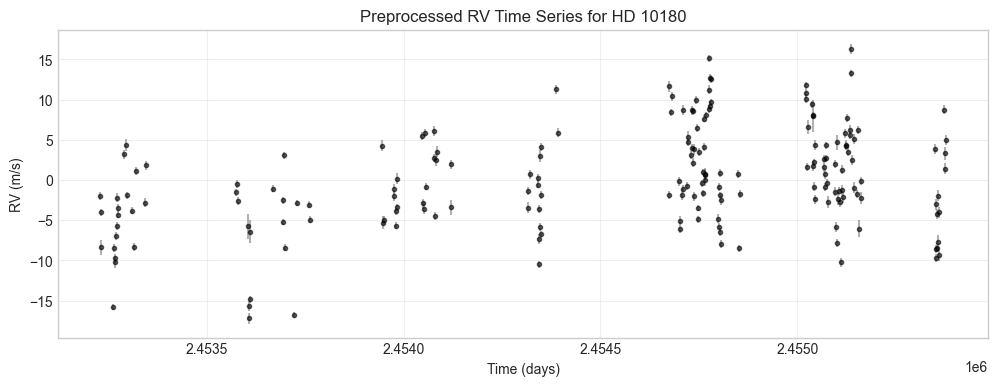

In [8]:
# Cell 1: Setup and Data Loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle

# --- Load the Data from CSV ---
# IMPORTANT: Replace 'hd10180_data.csv' with the actual path to your data file.
csv_filename = 'HD10180(Sheet1).csv'

try:
    # Use pandas to read the CSV file
    df = pd.read_csv(csv_filename, skiprows = 1)
   
    
    times = df.iloc[:, 0].values
    rv = df.iloc[:, 1].values*1000
    rv_err = df.iloc[:, 2].values*1000

    print(f"Successfully loaded {len(times)} data points for HD 10180 from {csv_filename}.")
    
except (IOError, KeyError) as e:
    print(f"ERROR: Could not read the data. Please check the following:")
    print(f"1. The filename '{csv_filename}' is correct.")
    print(f"2. The column names in the script match the names in your CSV file.")
    print(f"Error details: {e}")
    # Create placeholder data so the rest of the notebook can run
    times, rv, rv_err = np.linspace(0, 2000, 150), np.zeros(150), np.ones(150)


# --- Preprocess the Data ---
# 1. Convert time from BJD to days (optional, but good for cleaner numbers)
#    We subtract the first timestamp to start our time series at 0.
#times = times - times.min()

# 2. Mean-center the radial velocities
rv = rv - np.mean(rv)

# --- Plot the preprocessed data to verify ---
plt.figure(figsize=(12, 4))
plt.errorbar(times, rv, yerr=rv_err, fmt='.', color='k', ecolor='gray', alpha=0.6)
plt.title('Preprocessed RV Time Series for HD 10180')
plt.xlabel('Time (days)')
plt.ylabel('RV (m/s)')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def run_and_plot_analysis(times, data, uncertainties, freq_min, freq_max, n_freq_bins, nust_params):
    # Create the frequency grid for both analyses
    freq_grid = np.linspace(freq_min, freq_max, n_freq_bins)
    
    # 1. GLS Periodogram
    print("Calculating GLS Periodogram...")
    gls = LombScargle(times, data, uncertainties)
    power_gls = gls.power(freq_grid)
    
    # 2. NUST Spectrogram
    tau_grid = np.sort(times)
    print("Calculating NUST Spectrogram (this may take a moment)...")
    power_nust = nust(times, data, uncertainties, tau_grid, freq_grid, **nust_params)
    
    # 3. Create the plots (2 side-by-side)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
    
    # GLS
    ax1.plot(power_gls, freq_grid, color='k', lw=1.0)
    ax1.set_xlabel('GLS Power', fontsize=32)
    ax1.set_ylabel('Frequency (cycles/day)', fontsize=32)
    ax1.grid(True, alpha=0.3)
    
    # NUST
    im = ax2.pcolormesh(tau_grid, freq_grid, power_nust.T, shading='gouraud', cmap='plasma')
    ax2.set_xlabel('Time (days)', fontsize=32)
    
    # Colorbar (tighter)
    cbar = fig.colorbar(im, ax=ax2, shrink=0.9, pad=0.02)
    cbar.set_label('NUST Power (R²)', fontsize=20)

    # Minimize whitespace
    plt.tight_layout(pad=0.2, w_pad=0.5, h_pad=0.2)
    plt.savefig("gls_nust_comparison_c.png", dpi=300, bbox_inches="tight")
    plt.show()


In [11]:
def plot_nust_only(times, data, uncertainties, freq_min, freq_max, n_freq_bins, nust_params):
    """
    Plot only the NUST spectrogram with large ticks and labels.
    """
    # Frequency grid
    freq_grid = np.linspace(freq_min, freq_max, n_freq_bins)
    tau_grid = np.sort(times)
    
    print("Calculating NUST Spectrogram (this may take a moment)...")
    power_nust = nust(times, data, uncertainties, tau_grid, freq_grid, **nust_params)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(7, 5))
    
    # NUST spectrogram
    im = ax.pcolormesh(tau_grid, freq_grid, power_nust.T, shading='gouraud', cmap='plasma')
    ax.set_xlabel("Time (days)", fontsize=14)
    ax.set_ylabel("Frequency (cycles/day)", fontsize=14)
    
    # Bigger ticks
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.2, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=10, width=1, length=4)
    
    # Colorbar
    cbar = fig.colorbar(im, ax=ax, shrink=0.9, pad=0.02)
    cbar.set_label("NUST Power (R²)", fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    
    plt.tight_layout(pad=0.3)
    plt.show()


## hyper parameter visualisation for planet C

Loading data from HD10180(Sheet1).csv...
  Assuming data starts on row 2.
  Successfully loaded 190 time points.


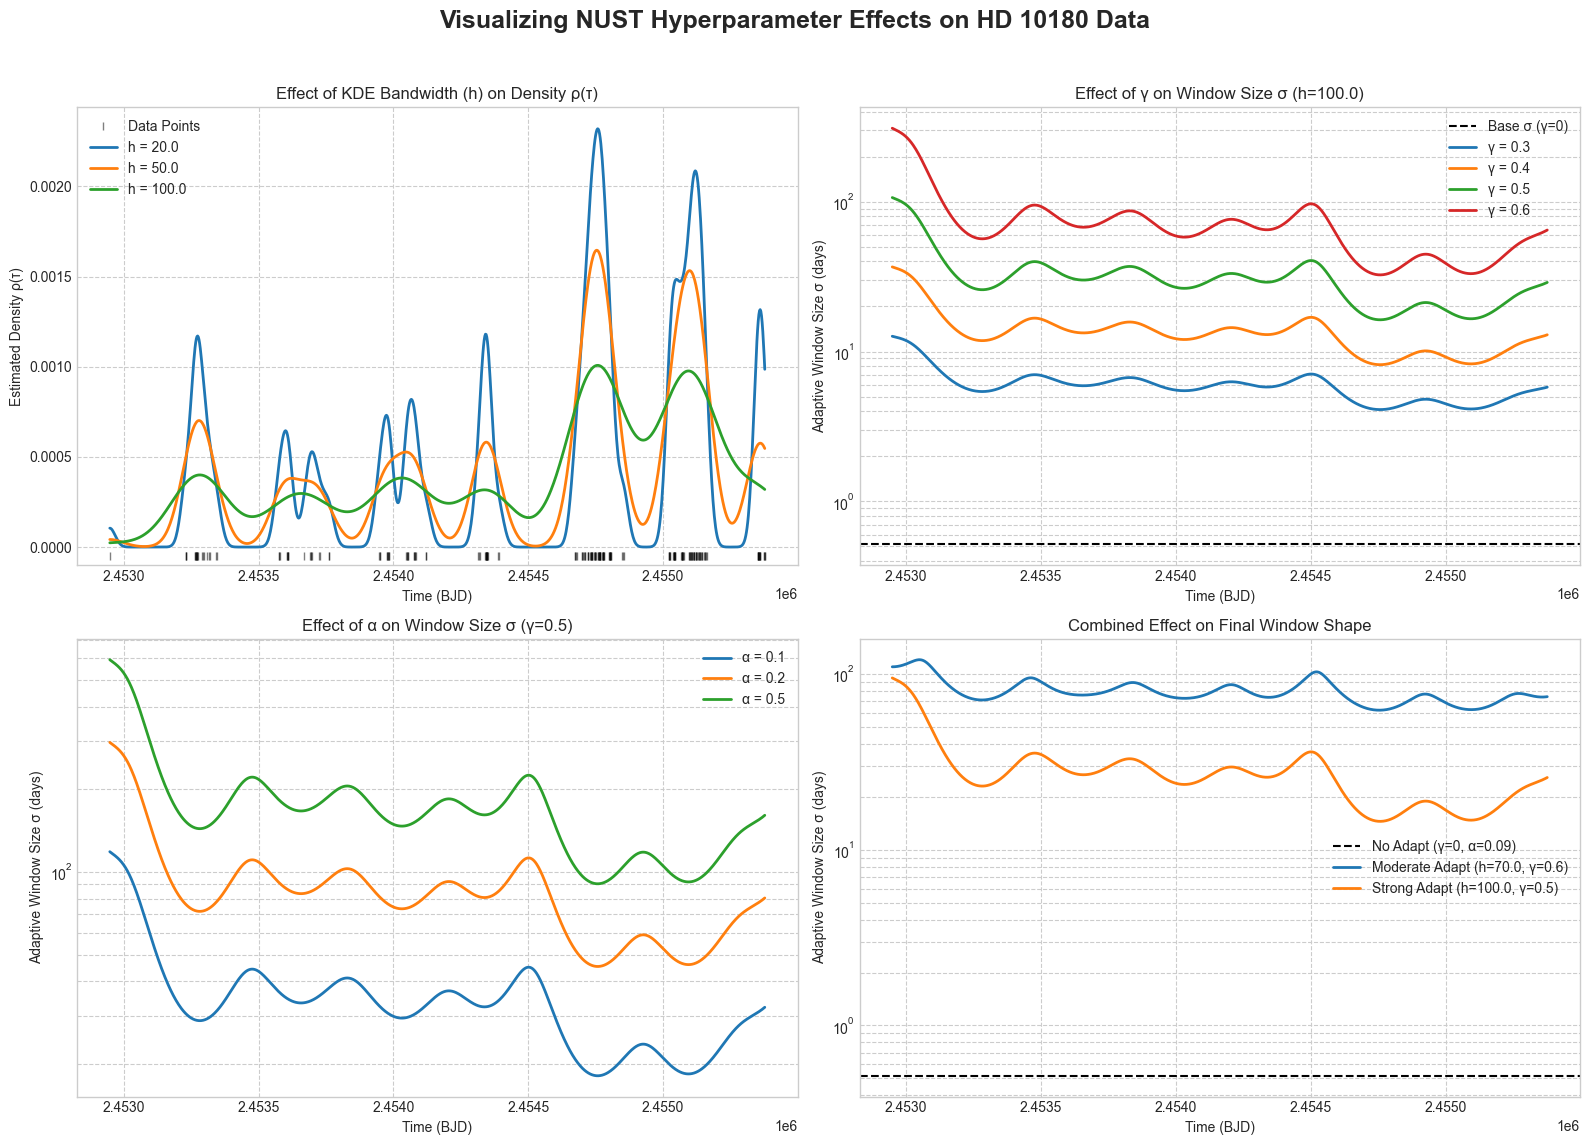

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def load_data_times_only(filepath):
    """
    Loads just the time series data from a CSV file for visualization purposes.
    """
    print(f"Loading data from {filepath}...")
    try:
        df = pd.read_csv(filepath, header=None)
    except FileNotFoundError:
        print(f"ERROR: File not found at '{filepath}'. Please check the file path.")
        return None
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return None

    first_data_row = 0
    for i, row in df.iterrows():
        try:
            pd.to_numeric(row.iloc[0]); pd.to_numeric(row.iloc[1])
            first_data_row = i
            break
        except (ValueError, TypeError): continue
    
    print(f"  Assuming data starts on row {first_data_row + 1}.")
    df = df.iloc[first_data_row:].copy()
    times = pd.to_numeric(df.iloc[:, 0]).values
    print(f"  Successfully loaded {len(times)} time points.")
    return times
def visualize_parameter_effects(times):
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Visualizing NUST Hyperparameter Effects on HD 10180 Data', fontweight='bold', fontsize=18)
    
    t_grid = np.linspace(times.min(), times.max(), 1000)
    
    # --- Plot 1: Effect of KDE bandwidth (h) ---
    ax1 = axes[0, 0]
    ax1.plot(times, np.zeros_like(times) - 0.00005, 'k|', alpha=0.5, label='Data Points')
    bandwidths_to_test = [20.0, 50.0, 100.0] # Bandwidths appropriate for this long time series
    for h in bandwidths_to_test:
        kde, _ = estimate_sampling_density_kde(times, bandwidth=h)
        if kde:
            ax1.plot(t_grid, kde(t_grid), lw=2, label=f'h = {h:.1f}')
    ax1.set_title('Effect of KDE Bandwidth (h) on Density ρ(τ)')
    ax1.set_xlabel('Time (BJD)')
    ax1.set_ylabel('Estimated Density ρ(τ)')
    ax1.legend()
    ax1.set_ylim(bottom=-0.0001)

    # --- Plot 2: Effect of Gamma (γ) on Window Adaptation ---
    ax2 = axes[0, 1]
    gammas_to_test = [0, 0.3, 0.4, 0.5, 0.6]
    kde_default, h_default = estimate_sampling_density_kde(times, bandwidth=100.0)
    test_freq = 0.174
    alpha_default = 0.09
    sigma_base = alpha_default / test_freq
    ax2.axhline(sigma_base, color='k', ls='--', label=f'Base σ (γ=0)')
    for gamma in gammas_to_test[1:]:
        window_sizes = [adaptive_window_std(tau, test_freq, kde_default, alpha_default, gamma) for tau in t_grid]
        ax2.plot(t_grid, window_sizes, lw=2, label=f'γ = {gamma:.1f}')
    ax2.set_title(f'Effect of γ on Window Size σ (h={h_default:.1f})')
    ax2.set_xlabel('Time (BJD)')
    ax2.set_ylabel('Adaptive Window Size σ (days)')
    ax2.legend()
    ax2.set_yscale('log')

    # --- Plot 3: Effect of Alpha (α) on Window Size ---
    ax3 = axes[1, 0]
    alphas_to_test = [0.1, 0.25, 0.5]
    gamma_default = 0.5
    for alpha in alphas_to_test:
        window_sizes = [adaptive_window_std(tau, test_freq, kde_default, alpha, gamma_default) for tau in t_grid]
        ax3.plot(t_grid, window_sizes, lw=2, label=f'α = {alpha:.1f}')
    ax3.set_title(f'Effect of α on Window Size σ (γ={gamma_default:.1f})')
    ax3.set_xlabel('Time (BJD)')
    ax3.set_ylabel('Adaptive Window Size σ (days)')
    ax3.legend()
    ax3.set_yscale('log')

    # --- Plot 4: Final Window Shape Comparison ---
    ax4 = axes[1, 1]
    # Configuration 1: No adaptation
    ax4.axhline(sigma_base, color='k', ls='--', label=f'No Adapt (γ=0, α={alpha_default})')
    # Configuration 2: Moderate adaptation
    kde_smooth, h_smooth = estimate_sampling_density_kde(times, bandwidth=70.0)
    sigma_moderate = [adaptive_window_std(tau, test_freq, kde_smooth, 4.0, 0.15) for tau in t_grid]
    ax4.plot(t_grid, sigma_moderate, lw=2, label=f'Moderate Adapt (h={h_smooth:.1f}, γ=0.6)')
    # Configuration 3: Strong adaptation
    kde_sharp, h_sharp = estimate_sampling_density_kde(times, bandwidth=100.0)
    sigma_strong = [adaptive_window_std(tau, test_freq, kde_sharp, 0.08, 0.5) for tau in t_grid]
    ax4.plot(t_grid, sigma_strong, lw=2, label=f'Strong Adapt (h={h_sharp:.1f}, γ=0.5)')
    ax4.set_title('Combined Effect on Final Window Shape')
    ax4.set_xlabel('Time (BJD)')
    ax4.set_ylabel('Adaptive Window Size σ (days)')
    ax4.legend()
    ax4.set_yscale('log')

    for ax in axes.flat:
        ax.grid(True, which='both', linestyle='--')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


# --- 3. EXECUTION BLOCK ---

if __name__ == '__main__':
    # Make sure this filename matches your CSV file
    DATA_FILE_PATH = "HD10180(Sheet1).csv"
    
    # Load just the time series from the real data file
    real_times = load_data_times_only(DATA_FILE_PATH)
    
    # Run the visualization function if the data was loaded successfully
    if real_times is not None:
        visualize_parameter_effects(real_times)


## NUST for planet C

High-frequency range: Using 200 frequency bins.
Calculating GLS Periodogram...
Calculating NUST Spectrogram (this may take a moment)...
Computing NUST (189τ x 200f = 37800 points)...
  Progress: 20%
  Progress: 39%
  Progress: 59%
  Progress: 78%
  Progress: 98%
NUST computation complete!


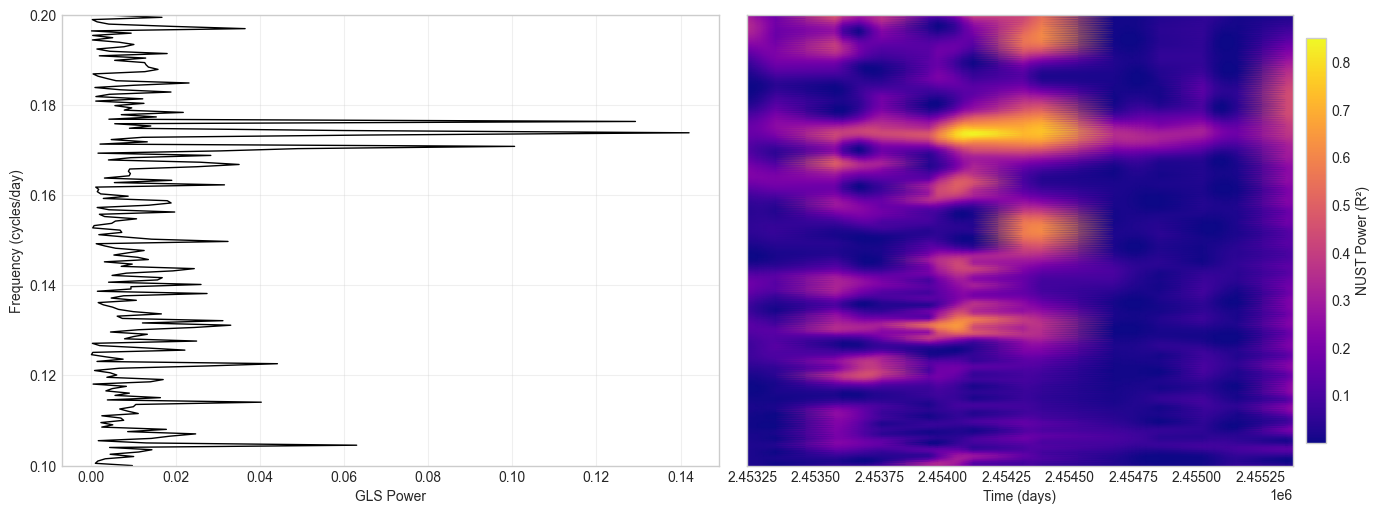

In [ ]:
# Define the frequency range
f_min_1, f_max_1 = 0.1, 0.2

# Calculate the "right" number of frequency bins
# We use an oversampling factor of 10 for a smooth plot
time_span = times.max() - times.min()
nyquist_resolution = 1.0 / time_span
oversampling_factor = 10
#n_bins_1 = int(oversampling_factor * (f_max_1 - f_min_1) / nyquist_resolution)
n_bins_1 = 200
print(f"High-frequency range: Using {n_bins_1} frequency bins.")

# Define NUST hyperparameters for this range
# For high frequencies, the window is naturally narrow.
# We might need a smaller KDE bandwidth to resolve sampling details.
nust_params_1 = {
    'use_voronoi_weights': False,
    'use_adaptive_window': True,
    'alpha': 4.0,
    'gamma': 0.15,
    'kde_bandwidth': 70.0 
}

# Run the analysis
run_and_plot_analysis(times, rv, rv_err, f_min_1, f_max_1, n_bins_1, nust_params_1)

## hyper parameter visualisation for planet D

Loading data from HD10180(Sheet1).csv...
  Assuming data starts on row 2.
  Successfully loaded 190 time points.


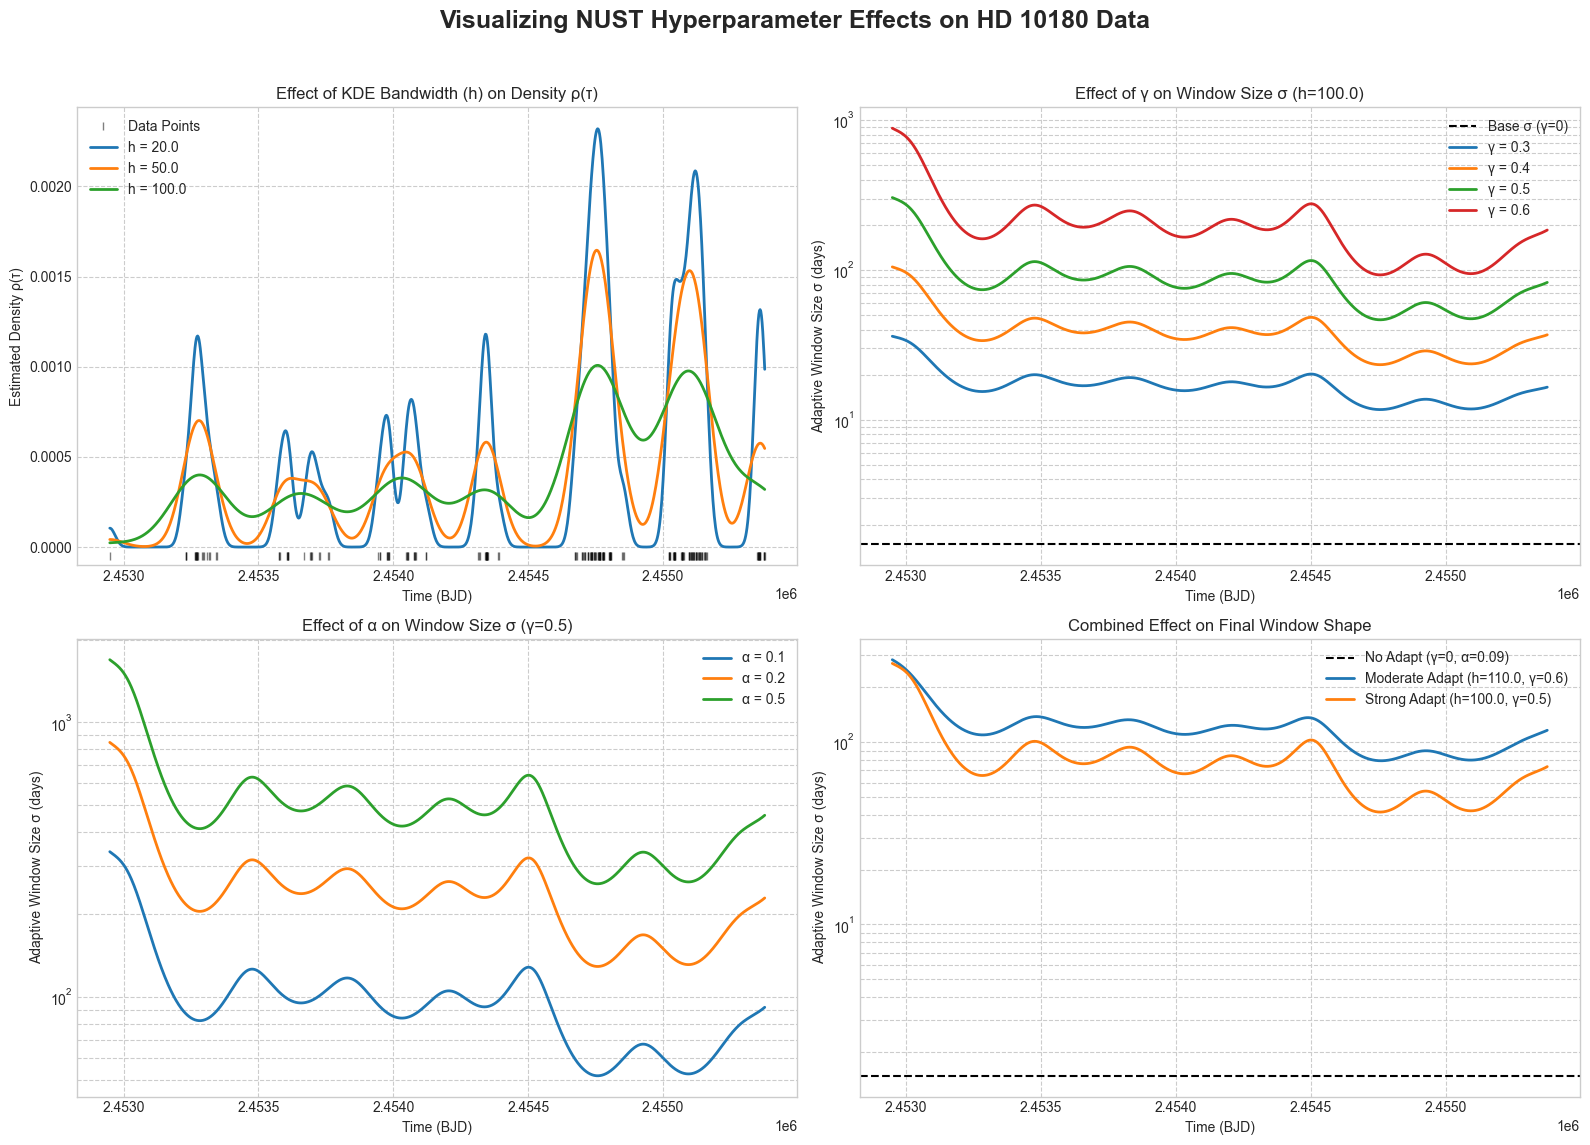

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def load_data_times_only(filepath):
    """
    Loads just the time series data from a CSV file for visualization purposes.
    """
    print(f"Loading data from {filepath}...")
    try:
        df = pd.read_csv(filepath, header=None)
    except FileNotFoundError:
        print(f"ERROR: File not found at '{filepath}'. Please check the file path.")
        return None
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return None

    first_data_row = 0
    for i, row in df.iterrows():
        try:
            pd.to_numeric(row.iloc[0]); pd.to_numeric(row.iloc[1])
            first_data_row = i
            break
        except (ValueError, TypeError): continue
    
    print(f"  Assuming data starts on row {first_data_row + 1}.")
    df = df.iloc[first_data_row:].copy()
    times = pd.to_numeric(df.iloc[:, 0]).values
    print(f"  Successfully loaded {len(times)} time points.")
    return times


def visualize_parameter_effects(times):
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Visualizing NUST Hyperparameter Effects on HD 10180 Data', fontweight='bold', fontsize=18)
    
    t_grid = np.linspace(times.min(), times.max(), 1000)
    
    # --- Plot 1: Effect of KDE bandwidth (h) ---
    ax1 = axes[0, 0]
    ax1.plot(times, np.zeros_like(times) - 0.00005, 'k|', alpha=0.5, label='Data Points')
    bandwidths_to_test = [20.0, 50.0, 100.0] # Bandwidths appropriate for this long time series
    for h in bandwidths_to_test:
        kde, _ = estimate_sampling_density_kde(times, bandwidth=h)
        if kde:
            ax1.plot(t_grid, kde(t_grid), lw=2, label=f'h = {h:.1f}')
    ax1.set_title('Effect of KDE Bandwidth (h) on Density ρ(τ)')
    ax1.set_xlabel('Time (BJD)')
    ax1.set_ylabel('Estimated Density ρ(τ)')
    ax1.legend()
    ax1.set_ylim(bottom=-0.0001)

    # --- Plot 2: Effect of Gamma (γ) on Window Adaptation ---
    ax2 = axes[0, 1]
    gammas_to_test = [0, 0.3, 0.4, 0.5, 0.6]
    kde_default, h_default = estimate_sampling_density_kde(times, bandwidth=100.0)
    test_freq = 0.0609
    alpha_default = 0.09
    sigma_base = alpha_default / test_freq
    ax2.axhline(sigma_base, color='k', ls='--', label=f'Base σ (γ=0)')
    for gamma in gammas_to_test[1:]:
        window_sizes = [adaptive_window_std(tau, test_freq, kde_default, alpha_default, gamma) for tau in t_grid]
        ax2.plot(t_grid, window_sizes, lw=2, label=f'γ = {gamma:.1f}')
    ax2.set_title(f'Effect of γ on Window Size σ (h={h_default:.1f})')
    ax2.set_xlabel('Time (BJD)')
    ax2.set_ylabel('Adaptive Window Size σ (days)')
    ax2.legend()
    ax2.set_yscale('log')

    # --- Plot 3: Effect of Alpha (α) on Window Size ---
    ax3 = axes[1, 0]
    alphas_to_test = [0.1, 0.25, 0.5]
    gamma_default = 0.5
    for alpha in alphas_to_test:
        window_sizes = [adaptive_window_std(tau, test_freq, kde_default, alpha, gamma_default) for tau in t_grid]
        ax3.plot(t_grid, window_sizes, lw=2, label=f'α = {alpha:.1f}')
    ax3.set_title(f'Effect of α on Window Size σ (γ={gamma_default:.1f})')
    ax3.set_xlabel('Time (BJD)')
    ax3.set_ylabel('Adaptive Window Size σ (days)')
    ax3.legend()
    ax3.set_yscale('log')

    # --- Plot 4: Final Window Shape Comparison ---
    ax4 = axes[1, 1]
    # Configuration 1: No adaptation
    ax4.axhline(sigma_base, color='k', ls='--', label=f'No Adapt (γ=0, α={alpha_default})')
    # Configuration 2: Moderate adaptation
    kde_smooth, h_smooth = estimate_sampling_density_kde(times, bandwidth=110.0)
    sigma_moderate = [adaptive_window_std(tau, test_freq, kde_smooth, 0.42, 0.35) for tau in t_grid]
    ax4.plot(t_grid, sigma_moderate, lw=2, label=f'Moderate Adapt (h={h_smooth:.1f}, γ=0.6)')
    # Configuration 3: Strong adaptation
    kde_sharp, h_sharp = estimate_sampling_density_kde(times, bandwidth=100.0)
    sigma_strong = [adaptive_window_std(tau, test_freq, kde_sharp, 0.08, 0.5) for tau in t_grid]
    ax4.plot(t_grid, sigma_strong, lw=2, label=f'Strong Adapt (h={h_sharp:.1f}, γ=0.5)')
    ax4.set_title('Combined Effect on Final Window Shape')
    ax4.set_xlabel('Time (BJD)')
    ax4.set_ylabel('Adaptive Window Size σ (days)')
    ax4.legend()
    ax4.set_yscale('log')

    for ax in axes.flat:
        ax.grid(True, which='both', linestyle='--')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


if __name__ == '__main__':
    # Make sure this filename matches your CSV file
    DATA_FILE_PATH = "HD10180(Sheet1).csv"
    
    # Load just the time series from the real data file
    real_times = load_data_times_only(DATA_FILE_PATH)
    
    # Run the visualization function if the data was loaded successfully
    if real_times is not None:
        visualize_parameter_effects(real_times)


## NUST for planet D

Mid-frequency range: Using 150 frequency bins.
Calculating GLS Periodogram...
Calculating NUST Spectrogram (this may take a moment)...
Computing NUST (189τ x 150f = 28350 points)...
  Progress: 20%
  Progress: 39%
  Progress: 59%
  Progress: 78%
  Progress: 98%
NUST computation complete!


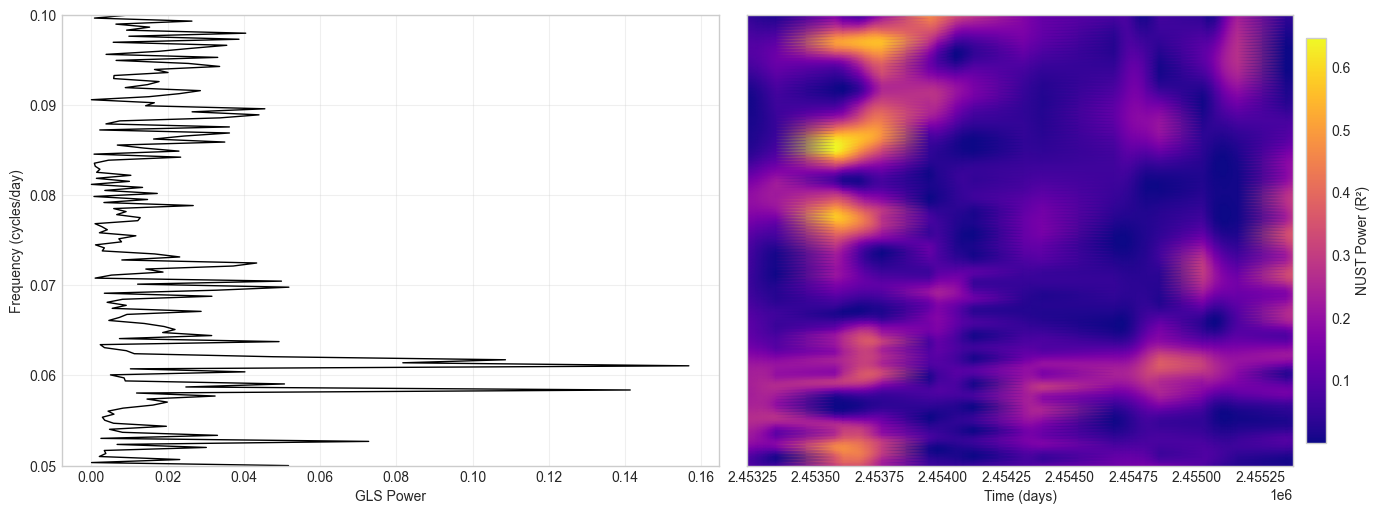

In [ ]:
# Define the frequency range
f_min_2, f_max_2 = 0.05, 0.1

# Calculate the number of frequency bins#
n_bins_2 = 150
#n_bins_2 = int(oversampling_factor * (f_max_2 - f_min_2) / nyquist_resolution)
print(f"Mid-frequency range: Using {n_bins_2} frequency bins.")

# Define NUST hyperparameters for this range
# We can use more standard parameters here.
nust_params_2 = {
    'use_voronoi_weights': False,
    'use_adaptive_window': True,
    'alpha': 0.29,
    'gamma': 0.4,
    'kde_bandwidth': 110.0 
}

# Run the analysis
run_and_plot_analysis(times, rv, rv_err, f_min_2, f_max_2, n_bins_2, nust_params_2)

## hyper parameter visualisation for planet E

Loading data from HD10180(Sheet1).csv...
  Assuming data starts on row 2.
  Successfully loaded 190 time points.


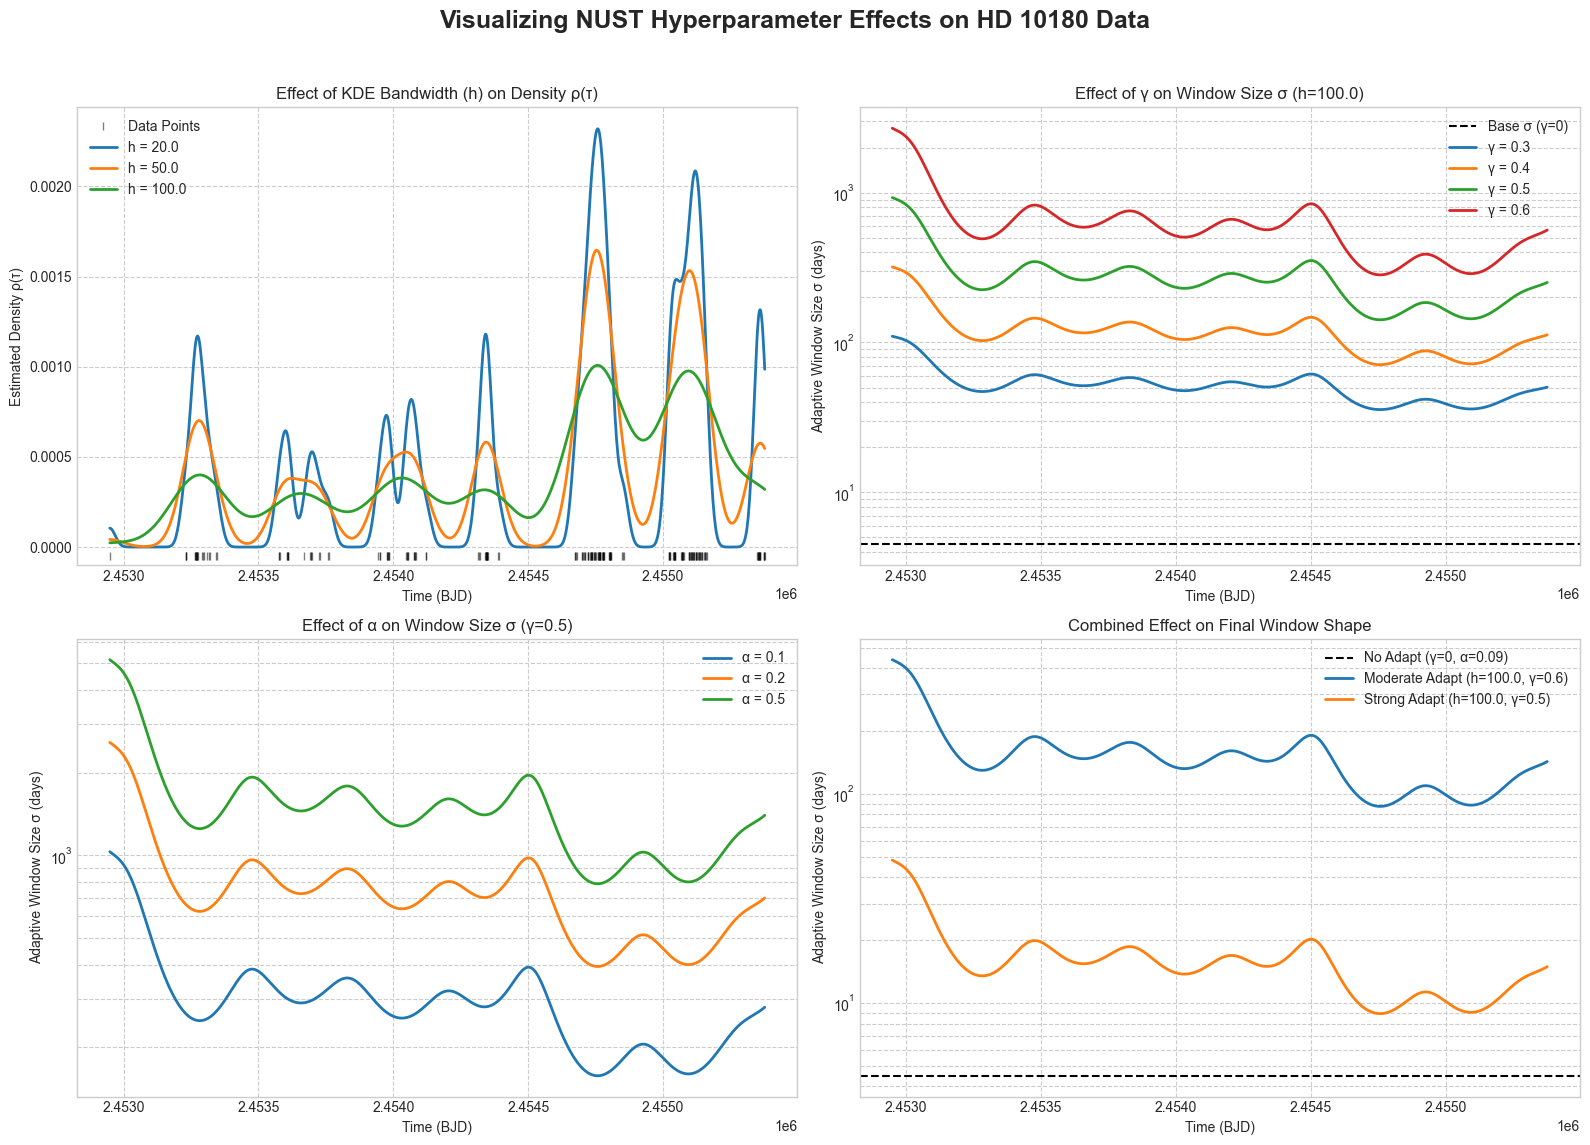

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def load_data_times_only(filepath):
    """
    Loads just the time series data from a CSV file for visualization purposes.
    """
    print(f"Loading data from {filepath}...")
    try:
        df = pd.read_csv(filepath, header=None)
    except FileNotFoundError:
        print(f"ERROR: File not found at '{filepath}'. Please check the file path.")
        return None
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return None

    first_data_row = 0
    for i, row in df.iterrows():
        try:
            pd.to_numeric(row.iloc[0]); pd.to_numeric(row.iloc[1])
            first_data_row = i
            break
        except (ValueError, TypeError): continue
    
    print(f"  Assuming data starts on row {first_data_row + 1}.")
    df = df.iloc[first_data_row:].copy()
    times = pd.to_numeric(df.iloc[:, 0]).values
    print(f"  Successfully loaded {len(times)} time points.")
    return times


def visualize_parameter_effects(times):
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Visualizing NUST Hyperparameter Effects on HD 10180 Data', fontweight='bold', fontsize=18)
    
    t_grid = np.linspace(times.min(), times.max(), 1000)
    
    # --- Plot 1: Effect of KDE bandwidth (h) ---
    ax1 = axes[0, 0]
    ax1.plot(times, np.zeros_like(times) - 0.00005, 'k|', alpha=0.5, label='Data Points')
    bandwidths_to_test = [20.0, 50.0, 100.0] # Bandwidths appropriate for this long time series
    for h in bandwidths_to_test:
        kde, _ = estimate_sampling_density_kde(times, bandwidth=h)
        if kde:
            ax1.plot(t_grid, kde(t_grid), lw=2, label=f'h = {h:.1f}')
    ax1.set_title('Effect of KDE Bandwidth (h) on Density ρ(τ)')
    ax1.set_xlabel('Time (BJD)')
    ax1.set_ylabel('Estimated Density ρ(τ)')
    ax1.legend()
    ax1.set_ylim(bottom=-0.0001)

    # --- Plot 2: Effect of Gamma (γ) on Window Adaptation ---
    ax2 = axes[0, 1]
    gammas_to_test = [0, 0.3, 0.4, 0.5, 0.6]
    kde_default, h_default = estimate_sampling_density_kde(times, bandwidth=100.0)
    test_freq = 0.02
    alpha_default = 0.09
    sigma_base = alpha_default / test_freq
    ax2.axhline(sigma_base, color='k', ls='--', label=f'Base σ (γ=0)')
    for gamma in gammas_to_test[1:]:
        window_sizes = [adaptive_window_std(tau, test_freq, kde_default, alpha_default, gamma) for tau in t_grid]
        ax2.plot(t_grid, window_sizes, lw=2, label=f'γ = {gamma:.1f}')
    ax2.set_title(f'Effect of γ on Window Size σ (h={h_default:.1f})')
    ax2.set_xlabel('Time (BJD)')
    ax2.set_ylabel('Adaptive Window Size σ (days)')
    ax2.legend()
    ax2.set_yscale('log')

    # --- Plot 3: Effect of Alpha (α) on Window Size ---
    ax3 = axes[1, 0]
    alphas_to_test = [0.1, 0.25, 0.5]
    gamma_default = 0.5
    for alpha in alphas_to_test:
        window_sizes = [adaptive_window_std(tau, test_freq, kde_default, alpha, gamma_default) for tau in t_grid]
        ax3.plot(t_grid, window_sizes, lw=2, label=f'α = {alpha:.1f}')
    ax3.set_title(f'Effect of α on Window Size σ (γ={gamma_default:.1f})')
    ax3.set_xlabel('Time (BJD)')
    ax3.set_ylabel('Adaptive Window Size σ (days)')
    ax3.legend()
    ax3.set_yscale('log')

    # --- Plot 4: Final Window Shape Comparison ---
    ax4 = axes[1, 1]
    # Configuration 1: No adaptation
    ax4.axhline(sigma_base, color='k', ls='--', label=f'No Adapt (γ=0, α={alpha_default})')
    # Configuration 2: Moderate adaptation
    kde_smooth, h_smooth = estimate_sampling_density_kde(times, bandwidth=100.0)
    sigma_moderate = [adaptive_window_std(tau, test_freq, kde_smooth, 0.09, 0.43) for tau in t_grid]
    ax4.plot(t_grid, sigma_moderate, lw=2, label=f'Moderate Adapt (h={h_smooth:.1f}, γ=0.6)')
    # Configuration 3: Strong adaptation
    kde_sharp, h_sharp = estimate_sampling_density_kde(times, bandwidth=100.0)
    sigma_strong = [adaptive_window_std(tau, test_freq, kde_sharp, 0.008, 0.45) for tau in t_grid]
    ax4.plot(t_grid, sigma_strong, lw=2, label=f'Strong Adapt (h={h_sharp:.1f}, γ=0.5)')
    ax4.set_title('Combined Effect on Final Window Shape')
    ax4.set_xlabel('Time (BJD)')
    ax4.set_ylabel('Adaptive Window Size σ (days)')
    ax4.legend()
    ax4.set_yscale('log')

    for ax in axes.flat:
        ax.grid(True, which='both', linestyle='--')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


if __name__ == '__main__':
    # Make sure this filename matches your CSV file
    DATA_FILE_PATH = "HD10180(Sheet1).csv"
    
    # Load just the time series from the real data file
    real_times = load_data_times_only(DATA_FILE_PATH)
    
    # Run the visualization function if the data was loaded successfully
    if real_times is not None:
        visualize_parameter_effects(real_times)


## NUST analysis for planet E (low frequency signal)

Low-frequency range: Using 80 frequency bins.
Calculating GLS Periodogram...
Calculating NUST Spectrogram (this may take a moment)...
Computing NUST (189τ x 80f = 15120 points)...
  Progress: 20%
  Progress: 39%
  Progress: 59%
  Progress: 78%
  Progress: 98%
NUST computation complete!


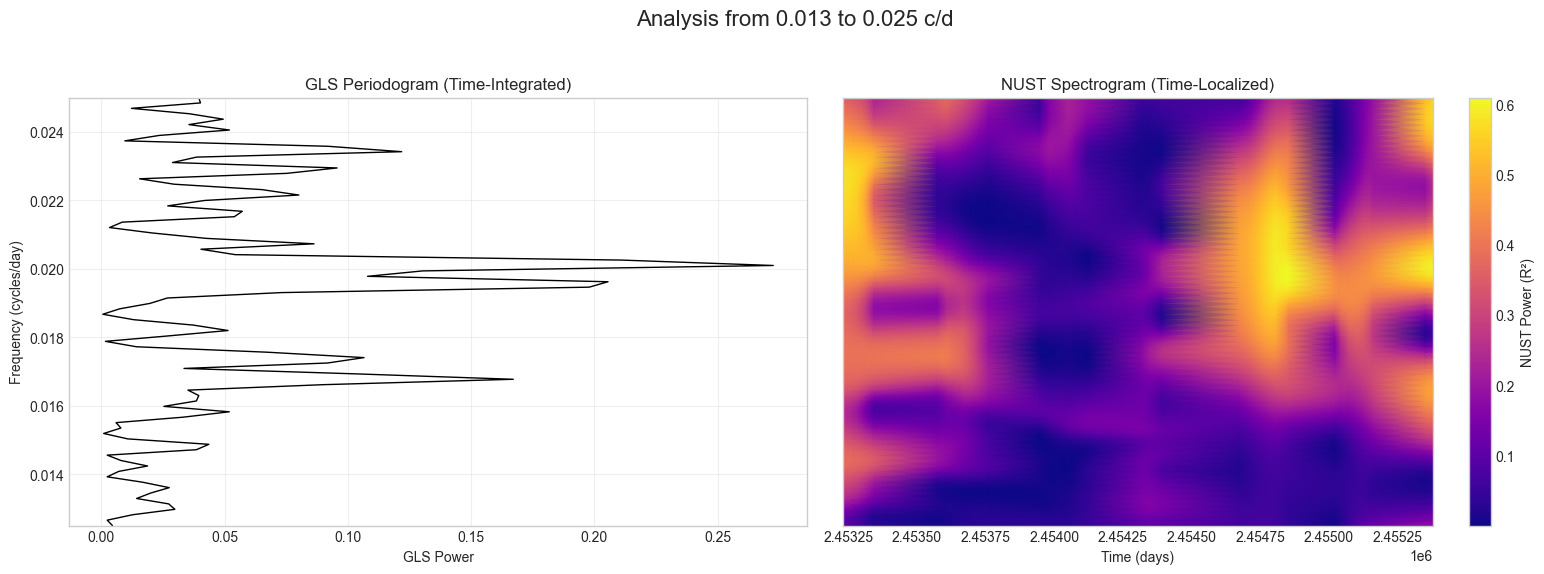

In [ ]:
# Run analysis for the low-frequency range

# Define the frequency range
f_min_3, f_max_3 = 0.0125, 0.025

# Calculate the number of frequency bins
n_bins_3 = 80
#n_bins_3 = int(oversampling_factor * (f_max_3 - f_min_3) / nyquist_resolution)
print(f"Low-frequency range: Using {n_bins_3} frequency bins.")

# Define NUST hyperparameters for this range
# For very low frequencies, the window is naturally very wide.
# A larger KDE bandwidth might be needed to smooth over many small gaps.
nust_params_3 = {
    'use_voronoi_weights': False,
    'use_adaptive_window': True,
    'alpha': 0.09,
    'gamma': 0.43, # May need to be more sensitive to density
    'kde_bandwidth': 100.0 
}

# Run the analysis
run_and_plot_analysis(times, rv, rv_err, f_min_3, f_max_3, n_bins_3, nust_params_3)

## hyper parameter visualisation for planet F

Loading data from HD10180(Sheet1).csv...
  Assuming data starts on row 2.
  Successfully loaded 190 time points.


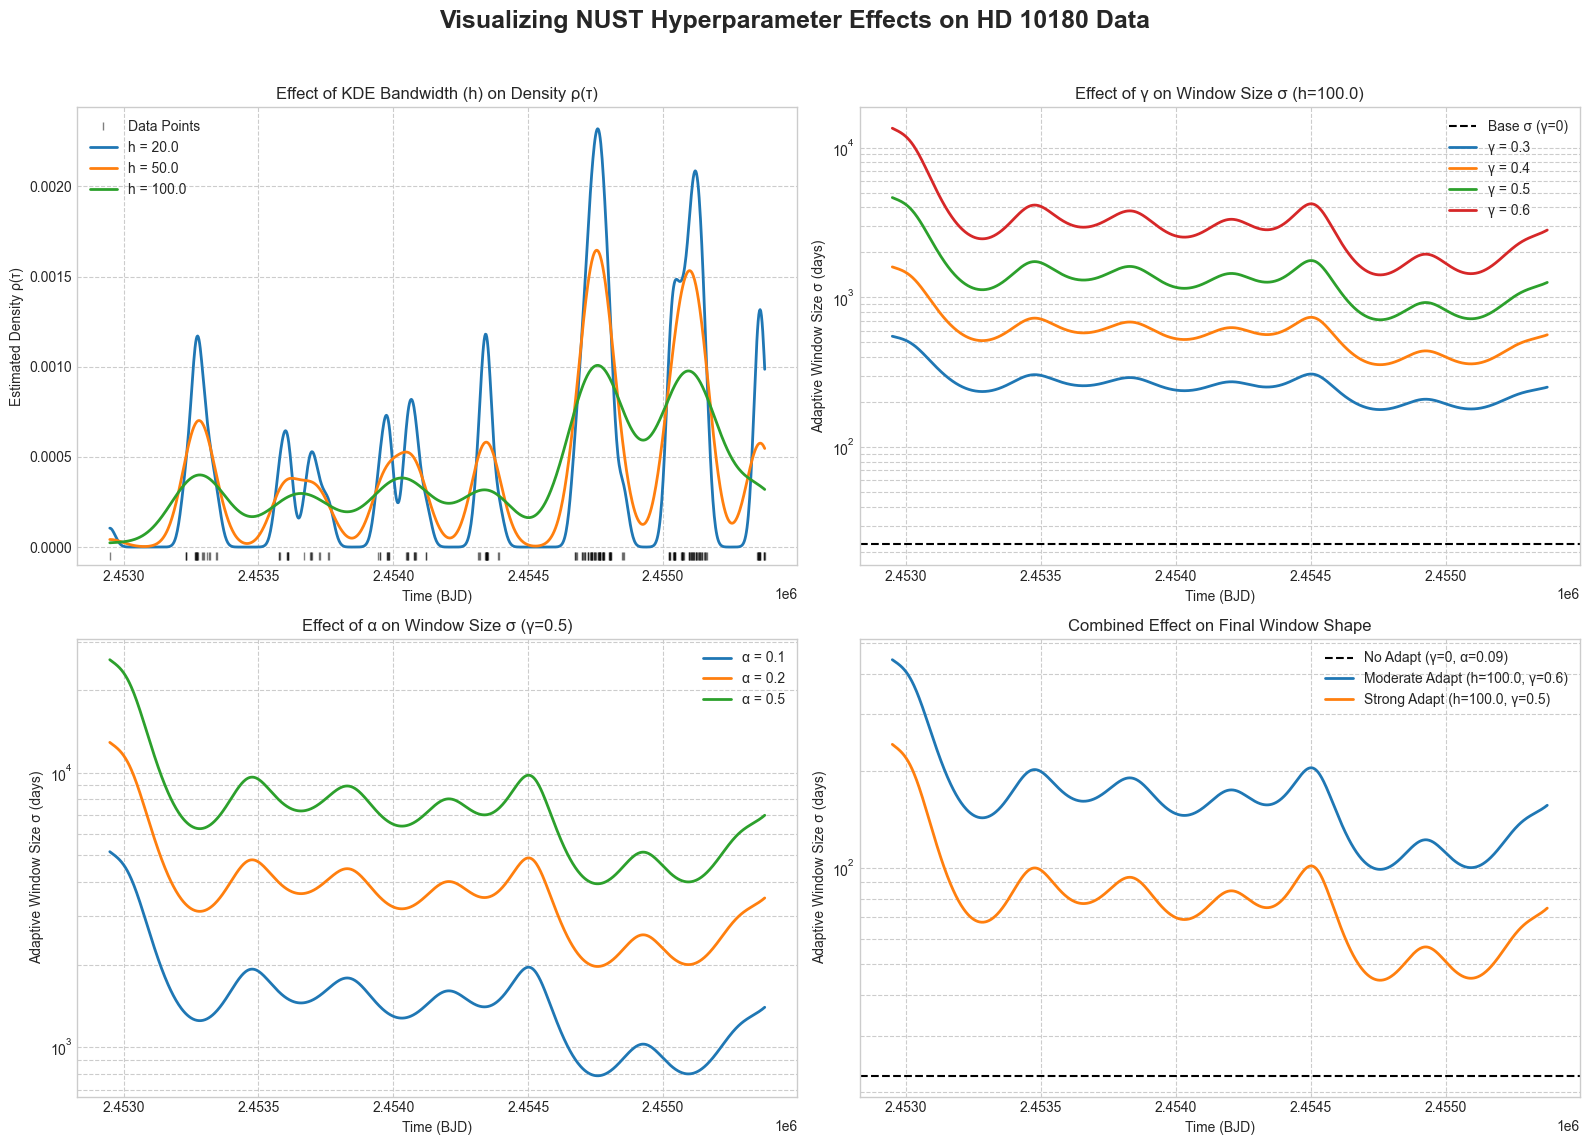

In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def load_data_times_only(filepath):
    """
    Loads just the time series data from a CSV file for visualization purposes.
    """
    print(f"Loading data from {filepath}...")
    try:
        df = pd.read_csv(filepath, header=None)
    except FileNotFoundError:
        print(f"ERROR: File not found at '{filepath}'. Please check the file path.")
        return None
    except Exception as e:
        print(f"An error occurred while reading the CSV file: {e}")
        return None

    first_data_row = 0
    for i, row in df.iterrows():
        try:
            pd.to_numeric(row.iloc[0]); pd.to_numeric(row.iloc[1])
            first_data_row = i
            break
        except (ValueError, TypeError): continue
    
    print(f"  Assuming data starts on row {first_data_row + 1}.")
    df = df.iloc[first_data_row:].copy()
    times = pd.to_numeric(df.iloc[:, 0]).values
    print(f"  Successfully loaded {len(times)} time points.")
    return times


# --- 2. YOUR VISUALIZATION FUNCTION ---
# (This is the plotting code you provided, unmodified)

def visualize_parameter_effects(times):
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Visualizing NUST Hyperparameter Effects on HD 10180 Data', fontweight='bold', fontsize=18)
    
    t_grid = np.linspace(times.min(), times.max(), 1000)
    
    # --- Plot 1: Effect of KDE bandwidth (h) ---
    ax1 = axes[0, 0]
    ax1.plot(times, np.zeros_like(times) - 0.00005, 'k|', alpha=0.5, label='Data Points')
    bandwidths_to_test = [20.0, 50.0, 100.0] # Bandwidths appropriate for this long time series
    for h in bandwidths_to_test:
        kde, _ = estimate_sampling_density_kde(times, bandwidth=h)
        if kde:
            ax1.plot(t_grid, kde(t_grid), lw=2, label=f'h = {h:.1f}')
    ax1.set_title('Effect of KDE Bandwidth (h) on Density ρ(τ)')
    ax1.set_xlabel('Time (BJD)')
    ax1.set_ylabel('Estimated Density ρ(τ)')
    ax1.legend()
    ax1.set_ylim(bottom=-0.0001)

    # --- Plot 2: Effect of Gamma (γ) on Window Adaptation ---
    ax2 = axes[0, 1]
    gammas_to_test = [0, 0.3, 0.4, 0.5, 0.6]
    kde_default, h_default = estimate_sampling_density_kde(times, bandwidth=100.0)
    test_freq = 0.004
    alpha_default = 0.09
    sigma_base = alpha_default / test_freq
    ax2.axhline(sigma_base, color='k', ls='--', label=f'Base σ (γ=0)')
    for gamma in gammas_to_test[1:]:
        window_sizes = [adaptive_window_std(tau, test_freq, kde_default, alpha_default, gamma) for tau in t_grid]
        ax2.plot(t_grid, window_sizes, lw=2, label=f'γ = {gamma:.1f}')
    ax2.set_title(f'Effect of γ on Window Size σ (h={h_default:.1f})')
    ax2.set_xlabel('Time (BJD)')
    ax2.set_ylabel('Adaptive Window Size σ (days)')
    ax2.legend()
    ax2.set_yscale('log')

    # --- Plot 3: Effect of Alpha (α) on Window Size ---
    ax3 = axes[1, 0]
    alphas_to_test = [0.1, 0.25, 0.5]
    gamma_default = 0.5
    for alpha in alphas_to_test:
        window_sizes = [adaptive_window_std(tau, test_freq, kde_default, alpha, gamma_default) for tau in t_grid]
        ax3.plot(t_grid, window_sizes, lw=2, label=f'α = {alpha:.1f}')
    ax3.set_title(f'Effect of α on Window Size σ (γ={gamma_default:.1f})')
    ax3.set_xlabel('Time (BJD)')
    ax3.set_ylabel('Adaptive Window Size σ (days)')
    ax3.legend()
    ax3.set_yscale('log')

    # --- Plot 4: Final Window Shape Comparison ---
    ax4 = axes[1, 1]
    # Configuration 1: No adaptation
    ax4.axhline(sigma_base, color='k', ls='--', label=f'No Adapt (γ=0, α={alpha_default})')
    # Configuration 2: Moderate adaptation
    kde_smooth, h_smooth = estimate_sampling_density_kde(times, bandwidth=100.0)
    sigma_moderate = [adaptive_window_std(tau, test_freq, kde_smooth, 0.025, 0.4) for tau in t_grid]
    ax4.plot(t_grid, sigma_moderate, lw=2, label=f'Moderate Adapt (h={h_smooth:.1f}, γ=0.6)')
    # Configuration 3: Strong adaptation
    kde_sharp, h_sharp = estimate_sampling_density_kde(times, bandwidth=100.0)
    sigma_strong = [adaptive_window_std(tau, test_freq, kde_sharp, 0.008, 0.45) for tau in t_grid]
    ax4.plot(t_grid, sigma_strong, lw=2, label=f'Strong Adapt (h={h_sharp:.1f}, γ=0.5)')
    ax4.set_title('Combined Effect on Final Window Shape')
    ax4.set_xlabel('Time (BJD)')
    ax4.set_ylabel('Adaptive Window Size σ (days)')
    ax4.legend()
    ax4.set_yscale('log')

    for ax in axes.flat:
        ax.grid(True, which='both', linestyle='--')

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


# --- 3. EXECUTION BLOCK ---

if __name__ == '__main__':
    # Make sure this filename matches your CSV file
    DATA_FILE_PATH = "HD10180(Sheet1).csv"
    
    # Load just the time series from the real data file
    real_times = load_data_times_only(DATA_FILE_PATH)
    
    # Run the visualization function if the data was loaded successfully
    if real_times is not None:
        visualize_parameter_effects(real_times)


## NUST analysis for planet F (lower frequency signal)

Low-frequency range: Using 60 frequency bins.
Calculating GLS Periodogram...
Calculating NUST Spectrogram (this may take a moment)...
Computing NUST (189τ x 60f = 11340 points)...
  Progress: 20%
  Progress: 39%
  Progress: 59%
  Progress: 78%
  Progress: 98%
NUST computation complete!


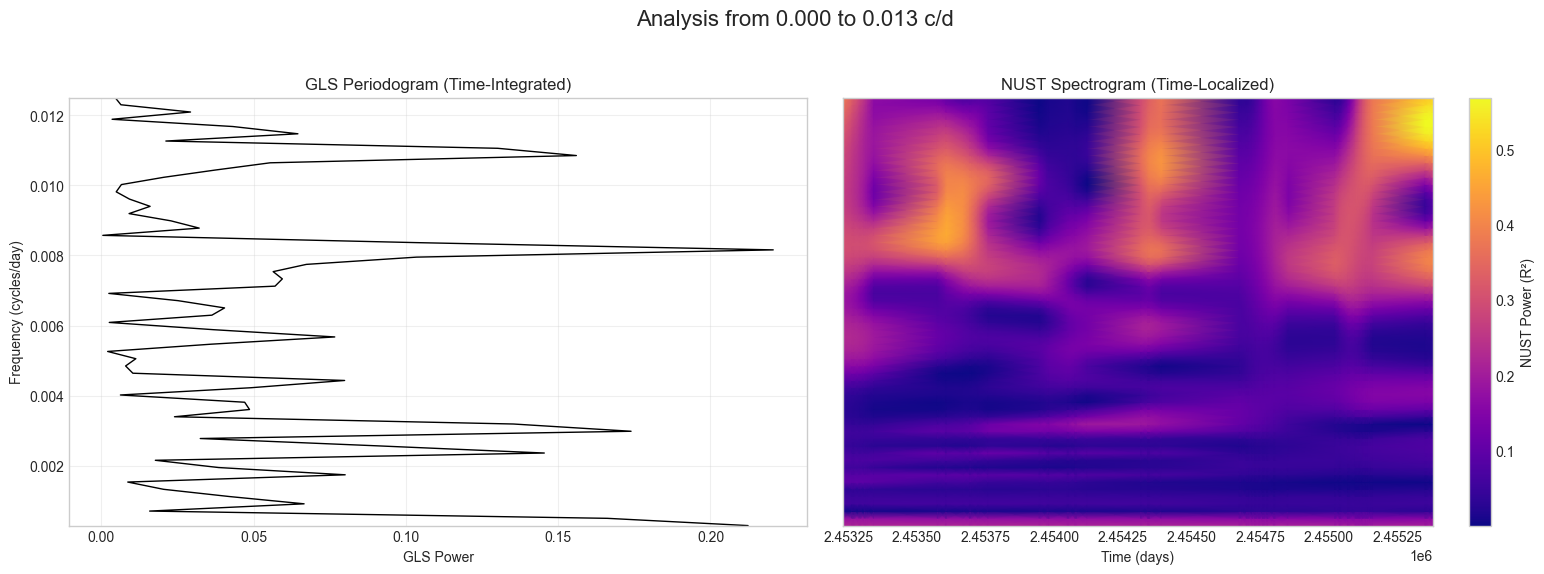

In [ ]:
# Run analysis for the low-frequency range

# Define the frequency range
f_min_4, f_max_4 = 0.0003, 0.0125

# Calculate the number of frequency bins
n_bins_4 = 60
#n_bins_4 = int(oversampling_factor * (f_max_4 - f_min_4) / nyquist_resolution)
print(f"Low-frequency range: Using {n_bins_4} frequency bins.")

# Define NUST hyperparameters for this range
# For very low frequencies, the window is naturally very wide.
# A larger KDE bandwidth might be needed to smooth over many small gaps.
nust_params_4 = {
    'use_voronoi_weights': False,
    'use_adaptive_window': True,
    'alpha': 0.04,
    'gamma': 0.43, # May need to be more sensitive to density
    'kde_bandwidth': 100.0 
}

# Run the analysis
run_and_plot_analysis(times, rv, rv_err, f_min_4, f_max_4, n_bins_4, nust_params_4)

## final plot for analysis

Computing NUST (189τ x 200f = 37800 points)...
  Progress: 20%
  Progress: 39%
  Progress: 59%
  Progress: 78%
  Progress: 98%
NUST computation complete!
Computing NUST (189τ x 150f = 28350 points)...
  Progress: 20%
  Progress: 39%
  Progress: 59%
  Progress: 78%
  Progress: 98%
NUST computation complete!


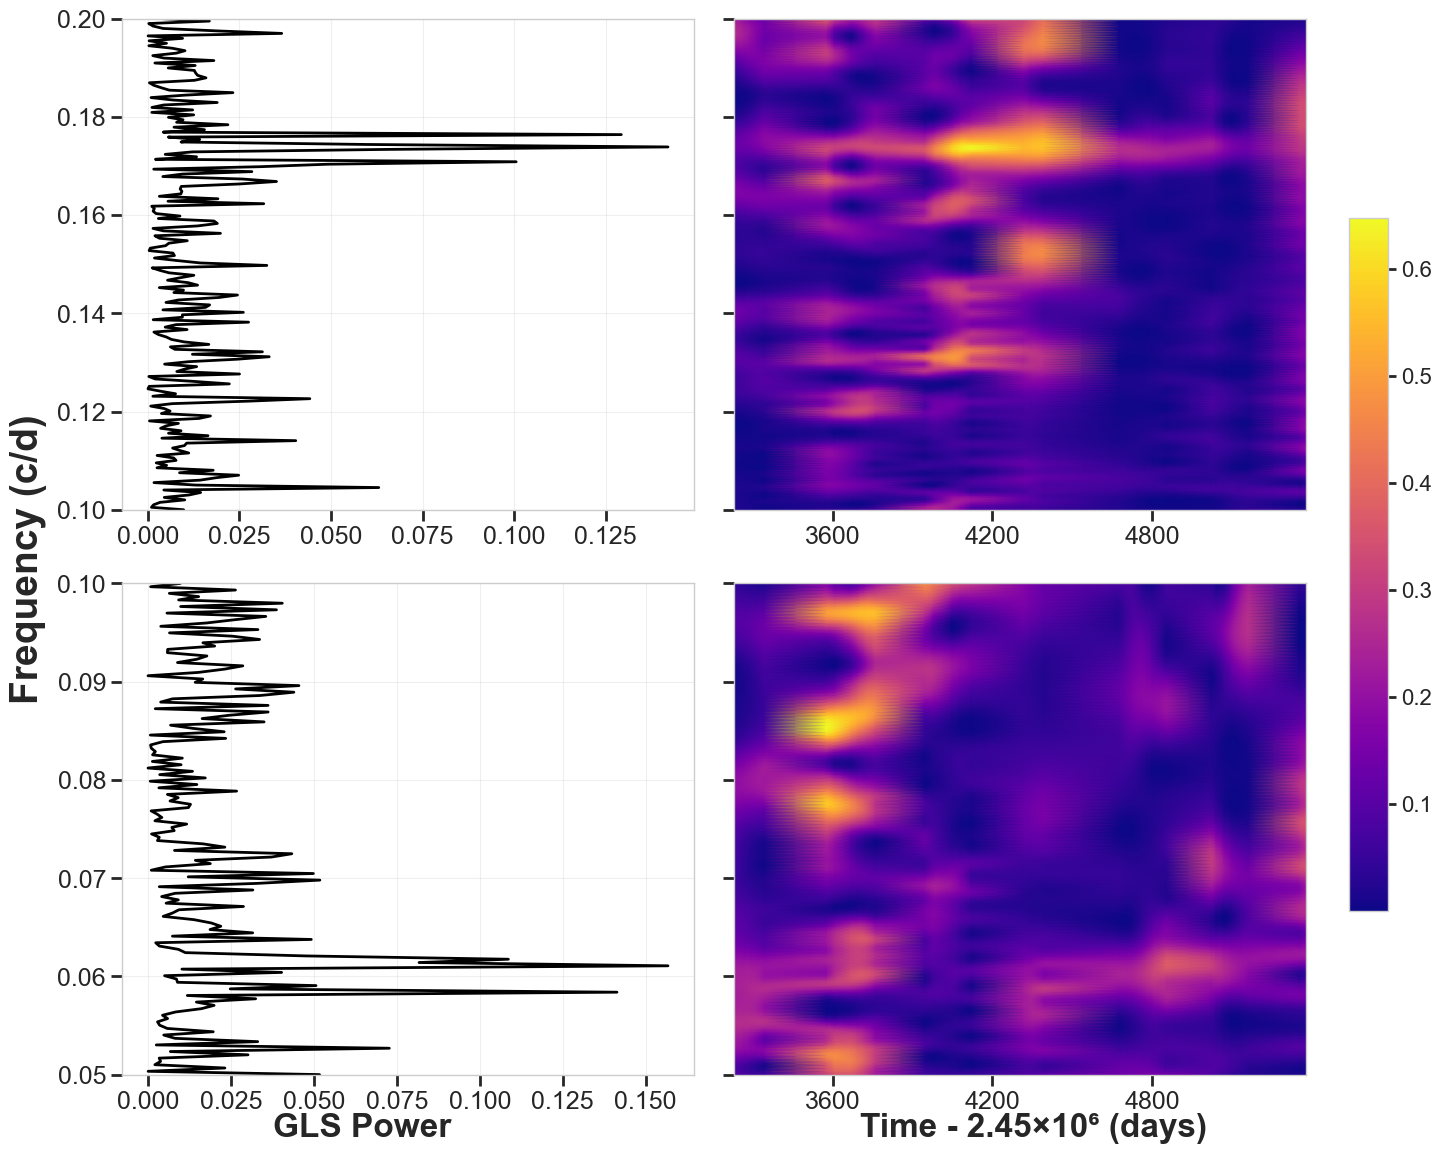

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle  # make sure you have astropy
# from your_nust_module import nust   # <-- replace with your NUST implementation


def run_gls_nust(times, data, uncertainties, freq_min, freq_max, n_freq_bins, nust_params):
    """
    Run GLS and NUST for given frequency range.
    Returns: freq_grid, power_gls, tau_grid, power_nust
    """
    freq_grid = np.linspace(freq_min, freq_max, n_freq_bins)

    # GLS
    gls = LombScargle(times, data, uncertainties)
    power_gls = gls.power(freq_grid)

    # NUST
    tau_grid = np.sort(times)
    power_nust = nust(times, data, uncertainties, tau_grid, freq_grid, **nust_params)

    return freq_grid, power_gls, tau_grid, power_nust


def plot_gls_nust_comparison(times, data, uncertainties):
    """
    Creates a 2x2 panel with GLS + NUST for two different frequency ranges.
    Enhanced for paper publication with better readability.
    """

    # --- First signal (high-frequency range) ---
    f_min_1, f_max_1, n_bins_1 = 0.1, 0.2, 200
    nust_params_1 = {
        'use_voronoi_weights': False,
        'use_adaptive_window': True,
        'alpha': 4.0,
        'gamma': 0.15,
        'kde_bandwidth': 70.0
    }
    freq_grid1, power_gls1, tau_grid, power_nust1 = run_gls_nust(
        times, data, uncertainties, f_min_1, f_max_1, n_bins_1, nust_params_1
    )

    # --- Second signal (mid-frequency range) ---
    f_min_2, f_max_2, n_bins_2 = 0.05, 0.1, 150
    nust_params_2 = {
        'use_voronoi_weights': False,
        'use_adaptive_window': True,
        'alpha': 0.29,
        'gamma': 0.4,
        'kde_bandwidth': 110.0
    }
    freq_grid2, power_gls2, _, power_nust2 = run_gls_nust(
        times, data, uncertainties, f_min_2, f_max_2, n_bins_2, nust_params_2
    )

    # --- Enhanced Plotting ---
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey="row")
    
    # Convert time: subtract 2.45e6 and keep in 1e6 scale
    baseline_time = 2.45e6
    tau_grid_offset = tau_grid - baseline_time
    
    # Top-left: GLS (high freq)
    ax1 = axes[0, 0]
    ax1.plot(power_gls1, freq_grid1, color='k', lw=2.0)
    ax1.tick_params(axis="both", which="major", labelsize=18, width=2, length=8)
    ax1.grid(True, alpha=0.3)

    # Top-right: NUST (high freq)
    ax2 = axes[0, 1]
    im = ax2.pcolormesh(tau_grid_offset, freq_grid1, power_nust1.T,
                        shading='gouraud', cmap="plasma")
    ax2.tick_params(axis="both", which="major", labelsize=18, width=2, length=8)
    
    # Format x-axis to show cleaner tick labels with bigger font
    ax2.xaxis.set_major_locator(plt.MaxNLocator(nbins=4, prune='both'))
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

    # Bottom-left: GLS (mid freq)
    ax3 = axes[1, 0]
    ax3.plot(power_gls2, freq_grid2, color='k', lw=2.0)
    ax3.tick_params(axis="both", which="major", labelsize=18, width=2, length=8)
    ax3.grid(True, alpha=0.3)

    # Bottom-right: NUST (mid freq)
    ax4 = axes[1, 1]
    im2 = ax4.pcolormesh(tau_grid_offset, freq_grid2, power_nust2.T,
                         shading='gouraud', cmap="plasma")
    ax4.tick_params(axis="both", which="major", labelsize=18, width=2, length=8)
    
    # Format x-axis to show cleaner tick labels with bigger font
    ax4.xaxis.set_major_locator(plt.MaxNLocator(nbins=4, prune='both'))
    ax4.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

    # Common labels using fig.text
    # Common GLS Power label (left side, centered)
    fig.text(0.23, 0.018, "GLS Power", ha="center", fontsize=24, fontweight='bold')
    
    # Common Time label (right side, centered) 
    fig.text(0.65, 0.018, "Time - 2.45×10⁶ (days)", ha="center", fontsize=24, fontweight='bold')

    # Frequency label - positioned to avoid overlap
    fig.text(0.01, 0.5, "Frequency (c/d)", va="center", rotation="vertical", 
             fontsize=28, fontweight='bold')

    # Clean colorbar without label - more aggressive spacing
    cbar = fig.colorbar(im2, ax=axes[:, 1], shrink=0.75, pad=0.08, location="right", aspect=18)
    cbar.ax.tick_params(labelsize=16, width=2, length=6)

    # Manual spacing adjustment with more right margin
    plt.subplots_adjust(left=0.08, right=0.82, top=0.95, bottom=0.07, hspace=0.15, wspace=0.07)

    # Save with high DPI for paper quality
    plt.savefig("gls_nust_2x2_panels_enhancedn.png", dpi=600, bbox_inches="tight", 
                facecolor='white', edgecolor='none')
    plt.show()


# --- Example Execution ---
plot_gls_nust_comparison(times, rv, rv_err)